In [1]:
# train validation

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline  
import cv2

from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import time
from funcs import models
import os
print 'All libs successfully loaded!'
from funcs.image import ImageDataGenerator
from funcs import utils
from funcs import misc

# current working directory
print os.getcwd() 

path2set="../dcom/TrainingSet/"
path2numpy = path2set+"numpy/"
path2nfolds=path2numpy+'nfolds/'
foldnm=1

# fix random seed for reproducibility
seed = 2016
np.random.seed(seed)

# configure plotting
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


Using Theano backend.


All libs successfully loaded!
/media/mra/win7/data/misc/UCI/Research/code/RV_seg_DeepLearning/notebook


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


__________________________________________________
please wait to load data ...
('X shape: ', (256, 216, 186))
('Y shape: ', (256, 216, 186))
('Min and Max X: ', 0, 1197)
('Min and Max Y: ', 0, 1)
Elapsed time: 0 seconds
__________________________________________________


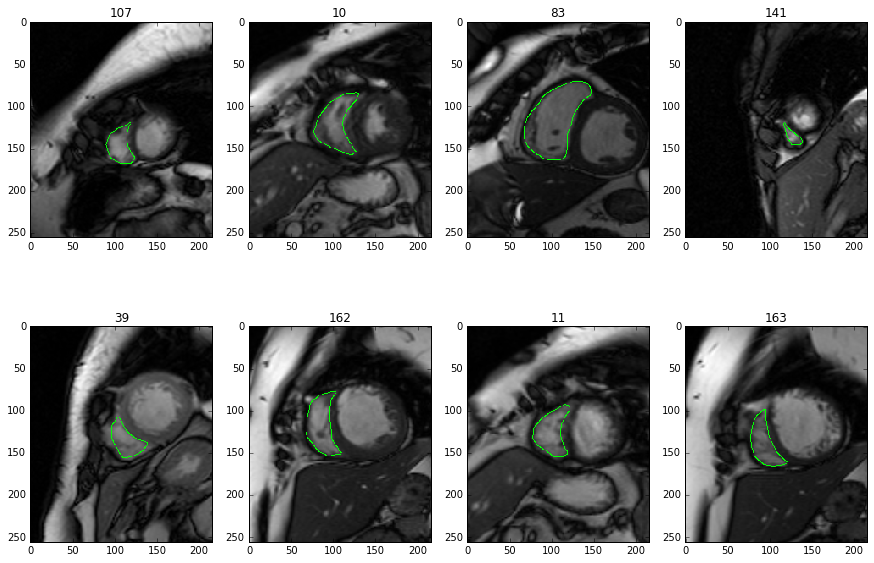

In [3]:
# load train data
X_train,Y_train=misc.load_data(path2nfolds + 'trainfold'+str(foldnm)+'.npz')


n1=misc.disp_img_mask(X_train,Y_train,2,4,2)


__________________________________________________
please wait to load data ...
('X shape: ', (256, 216, 57))
('Y shape: ', (256, 216, 57))
('Min and Max X: ', 0, 1060)
('Min and Max Y: ', 0, 1)
Elapsed time: 0 seconds
__________________________________________________


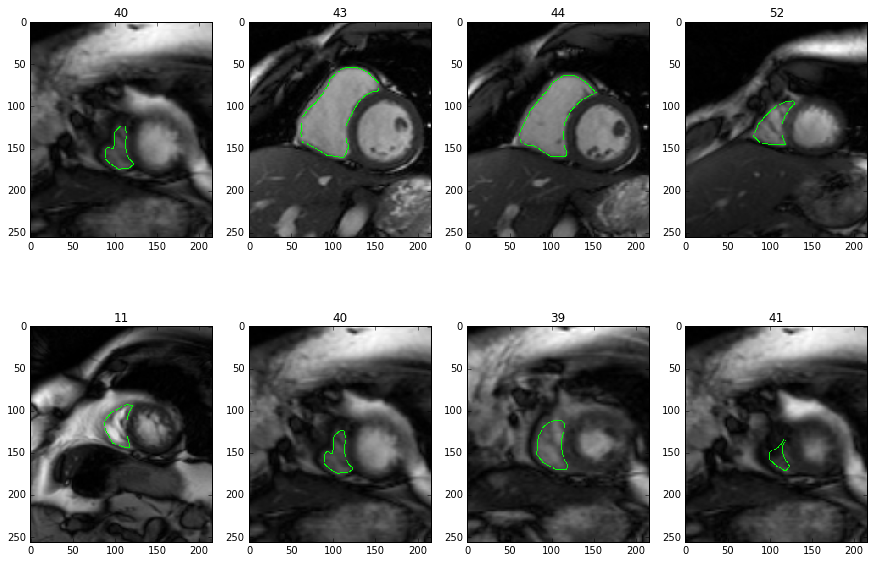

In [4]:
# load test data
X_test,Y_test=misc.load_data(path2nfolds + 'testfold'+str(foldnm)+'.npz')
plt.rcParams['figure.figsize'] = (15, 10)
n2=misc.disp_img_mask(X_test,Y_test,2,4,2)

__________________________________________________
__________________________________________________
please wait ...
Elapsed time: 0 seconds
__________________________________________________
please wait to resize images ...
('X_r size: ', (186, 1, 192, 192))
('Y_r size: ', (186, 1, 192, 192))
('Min and Max  X_r: ', -1.4898733, 8.357584)
('Min and Max  Y_r: ', 0, 1)
Elapsed time: 0 seconds
__________________________________________________


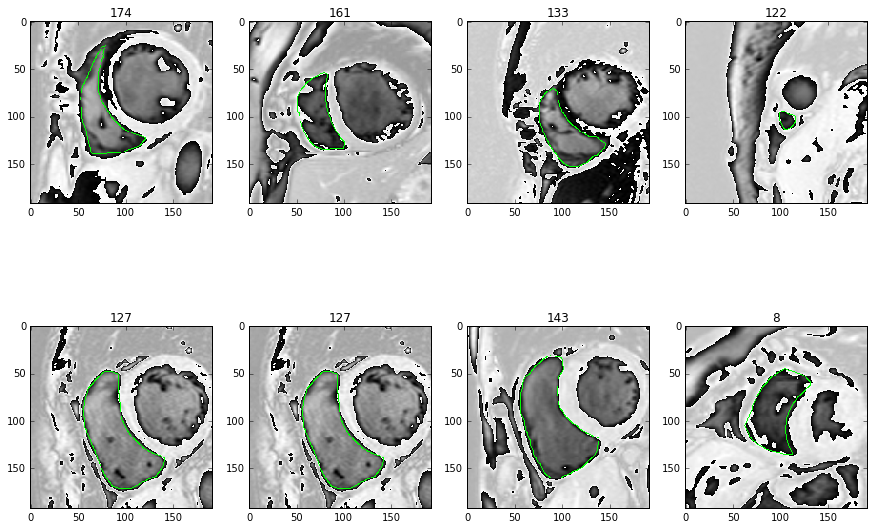

In [5]:
# preprocess train data     
params_preprocess={
    'row' : 192,
    'col' : 192,
    'imr' : 1,
    'crop': True,
    'crop_type': 'random',
    'normalization':True,
    }

# pre processing 
X_train_r,Y_train_r=misc.preprocess(X_train,Y_train,params_preprocess)

# display sample image
n1=misc.disp_img_mask(X_train_r,Y_train_r,2,4)

__________________________________________________
please wait to resize images ...
('X_r size: ', (57, 1, 192, 192))
('Y_r size: ', (57, 1, 192, 192))
('Min and Max  X_r: ', -1.5070901, 10.843662)
('Min and Max  Y_r: ', 0, 1)
Elapsed time: 0 seconds
__________________________________________________


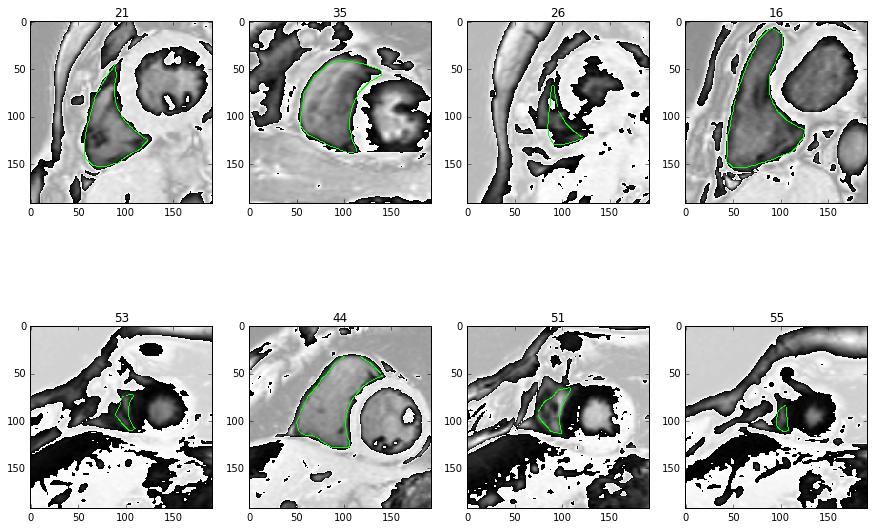

In [6]:
# preprocess test data     
params_preprocess={
    'row' : 192,
    'col' : 192,
    'imr' : 1,
    'crop': True,
    'crop_type': 'center',
    'normalization':True,
    }

# preprocess test data
X_test_r,Y_test_r=misc.preprocess(X_test,Y_test,params_preprocess)

# display sample image
n2=misc.disp_img_mask(X_test_r,Y_test_r,2,4)

In [7]:
# training params
params_train={
        'row': X_train_r.shape[2],
        'col': X_train_r.shape[3],           
        'weights': None,        
        'lr': 1e-4,
        'optimizer': 'Adam',
        'loss': 'dice_coef',
        'nbepoch': 500
        }

# build the model
model = models.model_dilated(params_train)
model.summary()


output pool1:  (None, 16, 96, 96)
output pool2:  (None, 32, 48, 48)
output pool3:  (None, 64, 48, 48)
output conv4:  (None, 64, 48, 48)
output conv4:  (None, 64, 48, 48)
output:  (None, 32, 96, 96)


/home/mra/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1142: UserWarning: ['filter_dilation'] are now deprecated in `tensor.nnet.abstract_conv.conv2d` interface and will be ignored.
  filter_dilation=filter_dilation)


output:  (None, 16, 192, 192)
output:  (None, 1, 192, 192)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 192, 192)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 192, 192)  160         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 16, 192, 192)  2320        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 96, 96)    0           convolution2d_2[0][0]            
________________________________

In [8]:
# random data generator
datagen = ImageDataGenerator(featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=75,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.05,
        zoom_range=0.01,
        channel_shift_range=0.0,
        fill_mode='nearest',
        cval=0.0,
        horizontal_flip=True,
        vertical_flip=True,
        dim_ordering='th') 

def iterate_minibatches(inputs1 , targets,  batchsize, shuffle=True, augment=True):
    assert len(inputs1) == len(targets)
 
    if shuffle:
        indices = np.arange(len(inputs1))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs1) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        x = inputs1[excerpt]
        y = targets[excerpt] 
        for  xxt,yyt in datagen.flow(x, y , batch_size=x.shape[0]):
            x = xxt.astype(np.float32) 
            y = yyt 
            break

    #yield x, np.array(y, dtype=np.uint8)         
    return x, np.array(y, dtype=np.uint8)         

X_train_aug,Y_train_aug=iterate_minibatches( X_train_r, Y_train_r , X_train_r.shape[0], shuffle=True)

array([113, 125,  52, 155, 102,  89,  70, 120])

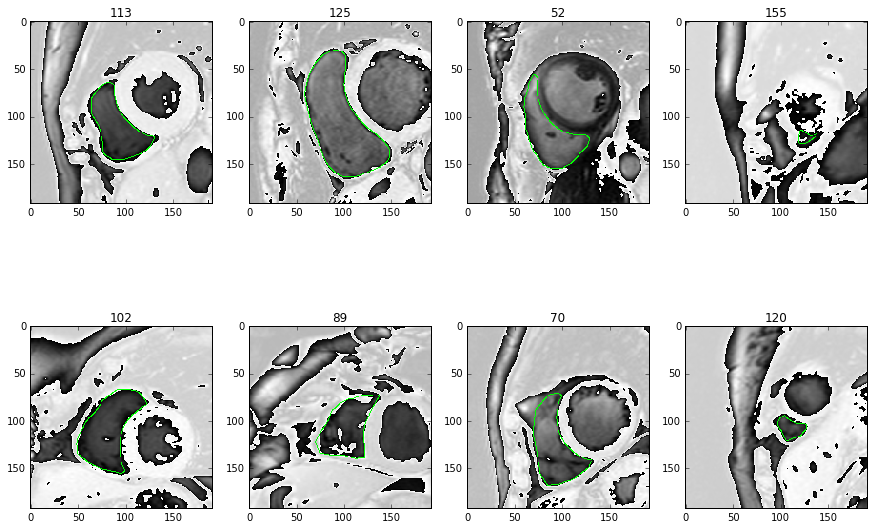

In [9]:
# display sample image after augmentation
misc.disp_img_mask(X_train_r,Y_train_r,2,4)

In [10]:
print 'training in progress ...'

# Direct the output to a log file and to screen
#loggerFileName = './output/logs'+'/log.txt'
#utils.initialize_logger(loggerFileName)

# checkpoint
# create numpy folder if does no exist
path2weights='./output/weights'
if  not os.path.exists('./output/weights'):
    os.makedirs(path2weights)
    print 'weights folder created'
filepath=path2weights+"/fold"+str(foldnm)+"-dilated-weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only='True',mode='min')


# Fit the model
start_time=time.time()
scores=[]
scores_train=[]
for e in range(params_train['nbepoch']):
    print 'epoch: %s' %e
    seed = np.random.randint(0, 999999)
    X_train_r,Y_train_r=misc.preprocess(X_train,Y_train,params_preprocess)
    X_train_aug,Y_train_aug=iterate_minibatches( X_train_r, Y_train_r , X_train_r.shape[0], shuffle=True)
    model.fit(X_train_aug, Y_train_aug, validation_data=(X_test_r, Y_test_r), nb_epoch=1, batch_size=8,verbose=0,shuffle=True,callbacks=[checkpoint])
    score=model.evaluate(X_test_r, Y_test_r,verbose=0)    
    score_train=model.evaluate(X_train_r, Y_train_r,verbose=0)    
    scores=np.append(scores,score[1])
    scores_train=np.append(scores_train,score_train[1])    
    print "train,test:", score_train[1],score[1]
    

print 'model was trained!'
elapsed_time=(time.time()-start_time)/60
print 'elapsed time: %d  mins' %elapsed_time


training in progress ...
epoch: 0
__________________________________________________
please wait to resize images ...
('X_r size: ', (186, 1, 192, 192))
('Y_r size: ', (186, 1, 192, 192))
('Min and Max  X_r: ', -1.6156638, 9.9224939)
('Min and Max  Y_r: ', 0, 1)
Elapsed time: 0 seconds
__________________________________________________
train,test: 0.155793670445 0.14964392912
epoch: 1
__________________________________________________
please wait to resize images ...
('X_r size: ', (186, 1, 192, 192))
('Y_r size: ', (186, 1, 192, 192))
('Min and Max  X_r: ', -1.6156638, 9.9224939)
('Min and Max  Y_r: ', 0, 1)
Elapsed time: 0 seconds
__________________________________________________
train,test: 0.177001814368 0.16922860475
epoch: 2
__________________________________________________
please wait to resize images ...
('X_r size: ', (186, 1, 192, 192))
('Y_r size: ', (186, 1, 192, 192))
('Min and Max  X_r: ', -1.6156638, 9.9224939)
('Min and Max  Y_r: ', 0, 1)
Elapsed time: 0 seconds
_____

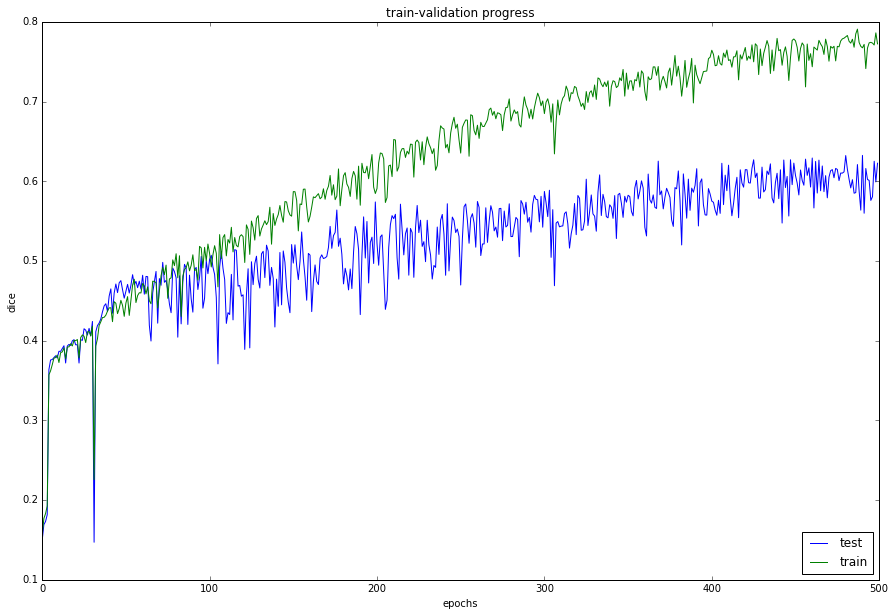

In [11]:
plt.plot(scores)
plt.plot(scores_train)
plt.title('train-validation progress')
plt.legend(('test','train'), loc = 'lower right')
plt.xlabel('epochs')
plt.ylabel('dice')

In [12]:
print 'please wait to test ...'
weights_path='./output/weights/fold'+str(foldnm)+"-dilated-weights.hdf5"
if os.path.isfile( weights_path):
    model.load_weights(weights_path)
    print 'weights loaded!'

# predic training data
print '-' *50
print 'please wait to test ...'
Y_train_pred=model.predict(X_train_r)
DM_train=misc.calc_dice(Y_train_r,Y_train_pred)
print 'Train data Dice Metric: %0.2f' %DM_train



please wait to test ...
weights loaded!
--------------------------------------------------
please wait to test ...
processing 0, dice= 0.75
processing 1, dice= 0.77
processing 2, dice= 0.84
processing 3, dice= 0.81
processing 4, dice= 0.83
processing 5, dice= 0.83
processing 6, dice= 0.62
processing 7, dice= 0.81
processing 8, dice= 0.75
processing 9, dice= 0.58
processing 10, dice= 0.59
processing 11, dice= 0.53
processing 12, dice= 0.47
processing 13, dice= 0.00
processing 14, dice= 0.17
processing 15, dice= 0.00
processing 16, dice= 0.81
processing 17, dice= 0.90
processing 18, dice= 0.84
processing 19, dice= 0.93
processing 20, dice= 0.82
processing 21, dice= 0.76
processing 22, dice= 0.85
processing 23, dice= 0.84
processing 24, dice= 0.76
processing 25, dice= 0.69
processing 26, dice= 0.57
processing 27, dice= 0.19
processing 28, dice= 0.06
processing 29, dice= 0.79
processing 30, dice= 0.83
processing 31, dice= 0.79
processing 32, dice= 0.81
processing 33, dice= 0.85
processing 

In [13]:
# predic test data
print '-' *50
print 'please wait to test ...'
Y_test_pred=model.predict(X_test_r)
DM_test=misc.calc_dice(Y_test_r,Y_test_pred)
print 'Test data Dice Metric: %0.2f' %DM_test


--------------------------------------------------
please wait to test ...
processing 0, dice= 0.90
processing 1, dice= 0.92
processing 2, dice= 0.41
processing 3, dice= 0.88
processing 4, dice= 0.67
processing 5, dice= 0.65
processing 6, dice= 0.45
processing 7, dice= 0.71
processing 8, dice= 0.46
processing 9, dice= 0.45
processing 10, dice= 0.27
processing 11, dice= 0.32
processing 12, dice= 0.02
processing 13, dice= 0.23
processing 14, dice= 0.07
processing 15, dice= 0.19
processing 16, dice= 0.86
processing 17, dice= 0.77
processing 18, dice= 0.79
processing 19, dice= 0.84
processing 20, dice= 0.79
processing 21, dice= 0.81
processing 22, dice= 0.76
processing 23, dice= 0.75
processing 24, dice= 0.75
processing 25, dice= 0.59
processing 26, dice= 0.68
processing 27, dice= 0.75
processing 28, dice= 0.49
processing 29, dice= 0.51
processing 30, dice= 0.23
processing 31, dice= 0.87
processing 32, dice= 0.80
processing 33, dice= 0.89
processing 34, dice= 0.69
processing 35, dice= 0.44

__________________________________________________
please wait to resize images ...
('X_r size: ', (57, 1, 192, 192))
('Y_r size: ', (57, 1, 192, 192))
('Min and Max  X_r: ', 0.0, 835.0)
('Min and Max  Y_r: ', 0, 1)
Elapsed time: 0 seconds
__________________________________________________


array([42, 39, 48, 35, 47, 42,  9, 43,  0, 16, 17, 26])

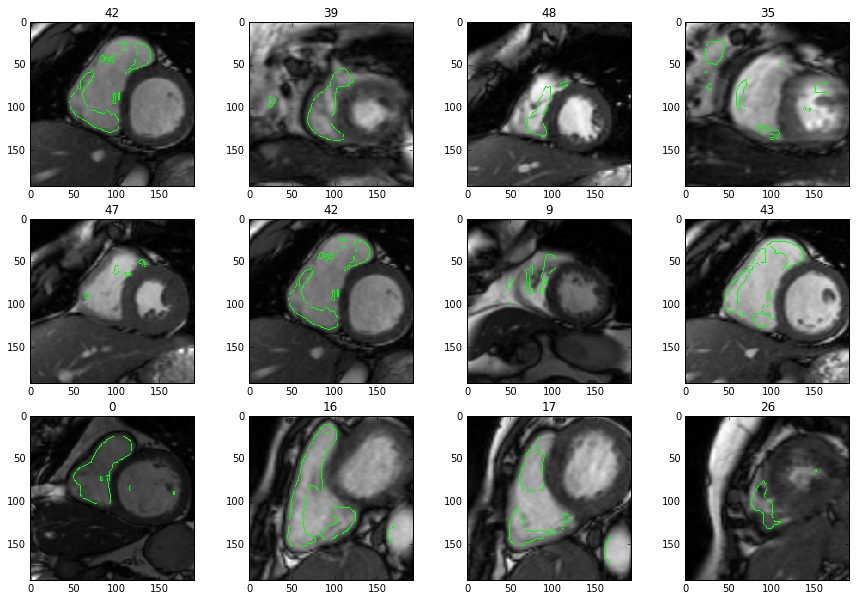

In [16]:
# preprocess test data     
params_preprocess={
    'row' : 192,
    'col' : 192,
    'imr' : 1,
    'crop': True,
    'crop_type': 'center',
    'normalization':False,
    }
# preprocess test data
X_test_r,Y_test_r=misc.preprocess(X_test,Y_test,params_preprocess)

misc.disp_img_mask(X_test_r,Y_test_pred,3,4)